# Creation of a synthetic K2-100 spectroscopic-like time-series
## Oscar Barragán, May 2021

In [2]:
#Imort modules
from __future__ import print_function, division, absolute_import
import numpy as np
#Import citlalatonac from pyaneti_extras, note that pyaneti has to be compiled in your machine
#and pyaneti has to be in your PYTHONPATH, e.g., you have to add in your bashrc file
#export PYTHONPATH=${PYTHONPATH}:/pathtopyaneti/pyaneti
#and replacing pathtopyaneti with the location of pyaneti in your machine
from pyaneti_extras.citlalatonac import citlali, create_real_times
#citli is the class that creates the spectroscopic-like time-series 

### let us summon `citlalatonac` powers and create synthetic stellar data for K2-100

We will create synthetic spectroscopic-like time-series for the star K2-100. We assume that the stellar induced radial velocity, $\log R'_{\rm HK}$, and Bisector-Span time-series can be described as

$$
    RV =  A_1 G(t) + B_1 \dot{G}(t), \\
    \log R'_{\rm HK} =  A_2 G(t) + B_2 \dot{G}(t), \\
    BIS =  A_3 G(t) + B_3 \dot{G}(t).
$$

We will use a quasi-periodic kernel (`kernel='QPK'`)
$$
    \gamma_{i,j} =  \exp 
    \left(
    - \frac{\sin^2\left[\pi \left(t_i - t_j \right)/P_{\rm GP}\right]}{2 \lambda_{\rm p}^2}
    - \frac{\left(t_i - t_j\right)^2}{2\lambda_{\rm e}^2}
    \right).
$$

Following [Barragán et al., 2019](https://academic.oup.com/mnras/article-abstract/490/1/698/5569669?redirectedFrom=fulltext), the amplitudes for this star are: 

$$A_1 = 0.0058, B_1=0.0421, A_2=0.0242, B_2=0.0, A_3=0.020,A_4=-0.086,$$

we pass to citlalatonac as `amplitudes=[0.0058,0.0421,0.0242,0.0,0.020,-0.086]`.

The hyper-parameters that describe the underlying Gaussian Process for K2-100 are 

 $$\lambda_e = 31.2, \lambda_p = 0.558, P_{\rm GP} = 4.315 $$ 

that we given as `kernel_parameters=[31.2,0.558,4.135]`. 

In this case we will create 3 timeseries (`nseries=3`) between 7760 (`tmin`) and 7820 (`tmax`) BJD - 2450000 (Note that for the creation of the time-series, the units of the time are not important, but they become important when we want to create data for a target at a given observatory, as we will see below).

We will also name our time_series as rhk and bis, for $\log R'_{\rm HK}$ and $BIS$, respectively. By default, the first time-series is always called rvs.

We can also pas a `seed` for the random number generator.

## Creating the underlying astrophysical signal

In [3]:
#Do all the previous description with one Python command
star = citlali(tmin=7760,tmax=7860,nseries=3,kernel='QPK',kernel_parameters=[31.2,0.558,4.135],
           amplitudes=[0.0058,0.0421,0.0242,0.0,0.020,-0.086],seed=1,time_series=['rhk','bis'])

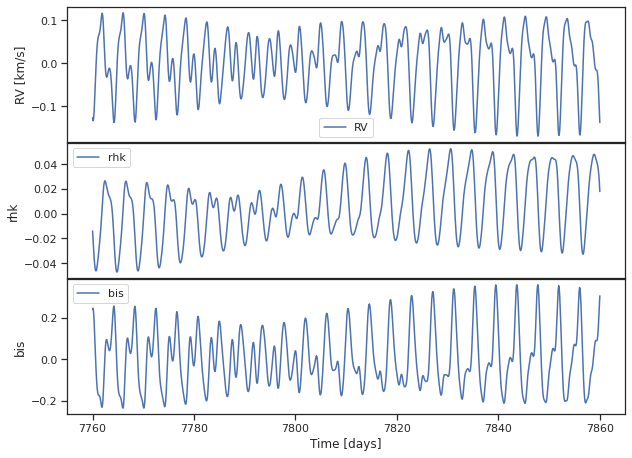

In [4]:
#Let us see how the 3 time-series look
star.plot()

We can see that the behavior of the signal is similar to the one obtained analysing the real data set. See Figure 2 of [Barragán et al., 2019](https://academic.oup.com/mnras/article-abstract/490/1/698/5569669?redirectedFrom=fulltext). Now that we have the stellar variability model, we can add the planetary signal in the RV-like data set.

## Time to add the planetary signal

To add a planetary signal, we have to call the `add_planet` method. We need to pass two elements to the method, the first one is a list constaining the plantary and orbital parameters

`planet_params = [T0,K,P,e,w]`, 

being `T0` the time of minimum conjunction (time of transit for transiting planets), `K` planet induced Doppler semi-amplitude, `P` is the planet orbital period, `e` is orbital eccentricty, and `w` is the angle of periastron. We also need to pass a string to label the planet 

`planet_name = planet_b`

In this example we will add `planet_name = K2-100b` with parameters

$T0,K,P,e,w = 7140.71951,0.0106,1.6739035,0,\pi/2$

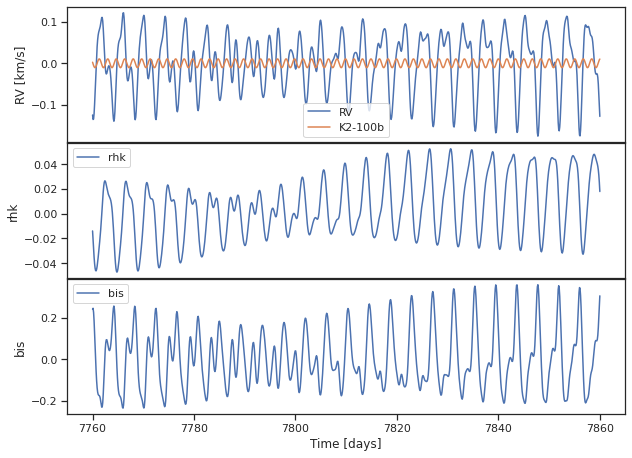

In [5]:
#let us create the lists with the both planet parameters that we will pass to the add_planet attribute
k2100_pars = [7140.71951,0.0106,1.6739035,0,np.pi/2]
#Let us call the add_planet instance for the instrument i1 and let's call the planet 'b'
star.add_planet(k2100_pars,'K2-100b')
#Let us plot the time-series to see if we have added the planetary signal
star.plot()

At this point we have a model of the three signals created following the same underlying GP $G(t)$. Now it is time to create data taken at the times $\mathbf{t}$ that we can specify. 

## Create data assuming we observe K2-100 from La Palma

The `citlalatonac` package contains the create_real_times function that allow us to estimate the times at which a given target is observed from a observatory with an airmass limit. In this example we will assume that we want to collect 50 epochs of K2-100 from La Palma Observatory with an airmass limit of 1.5. We can do this by calliny the `create_real_times` with the parameters

`create_real_times(tmin,tmax,ndata=50,air_mass_limit=1.5,tformat='mjd',star='K2-100',observatory='lapalma')`

for more details about the observatories and targets see [`astropy` documentation](https://astroplan.readthedocs.io/en/latest/tutorials/summer_triangle.html).

In [6]:
#Get the times at which K2-100 is observed from La Palma between the time of our synthetic data
t_k2100 = create_real_times(star.time.min(),star.time.max(),ndata=50,air_mass_limit=1.5,
                            tformat='mjd',star='K2-100',observatory='lapalma')

Now we have the times $\mathbf{t}$ at which we want to create our observations, we can do this by calling the create_data method.

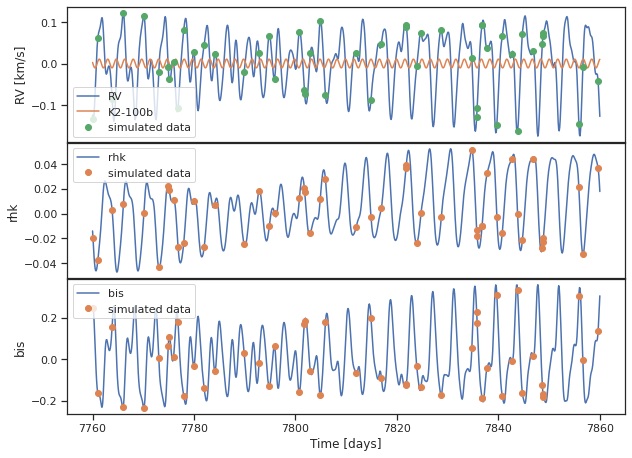

In [7]:
#Let us create the data at times t
star.create_data(t=t_k2100)
#Let us see how our observations
star.plot()

### Adding white noise to our data

The previous plot shows the positions at which we have created our observations. We still need to add some white noise to make the situation more realistic. We do this by passing an error bar for each time-series that we have created. We assume that our error bars are of 0.005 for the RV data, 0.01 for the $\log R'_{\rm HK}$ data, and 0.05 for the BIS data. We do this by calling the `add_white_noise` method and pass
`err=[0.005,0.01,0.05]`.

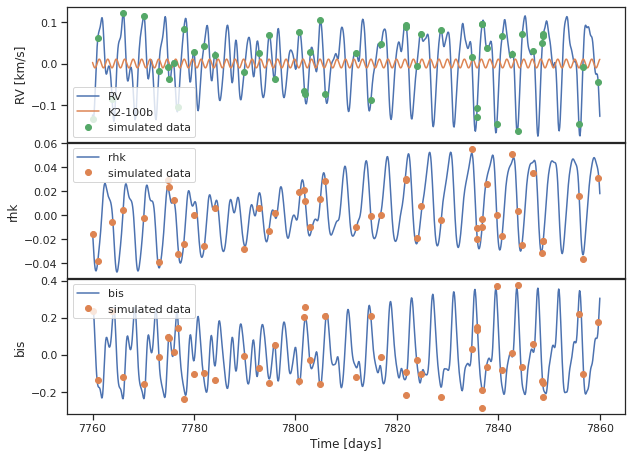

In [8]:
#The input vector err has to have one white noise term per each time-series
star.add_white_noise(err=[0.001,0.005,0.050])
star.plot()

### Adding red noise to our data

In real life, spectroscopic time-series also contain red-noise that can be caused by instrumental systematics.
Therefore, if we want to use `citlalatonac` to simulate realistic data sets for our stars, we need to include this effects in our simulated data sets. The `add_red_noise` allows to add extra dispersion in the data that is not included in the nonimal error bars that are given to the data when adding white noise. The red noise is added with a GP following a Square-exponential kernel $\gamma = A^2 \exp[(t_i-t_j)^2/2\lambda^2]$. If we assume that the instrument with which we plan to observe K2-100 has nigth to night variations of 0.001, then we can add red noise assuming that $A = 0.001$, and $\lambda = 1$ as `se_parameters=[0.001,1]`.

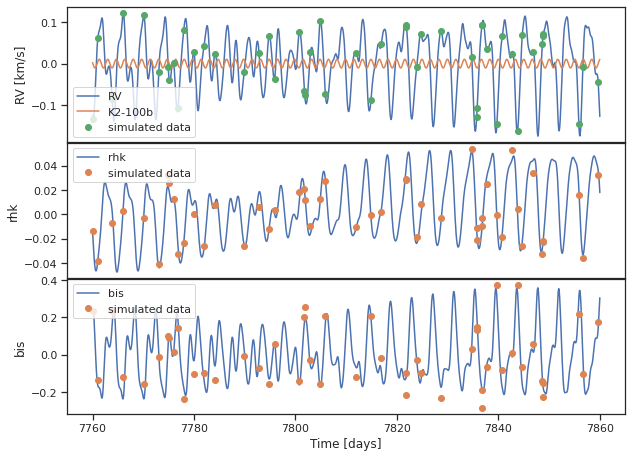

In [9]:
star.add_red_noise(se_parameters=[0.001,1])
star.plot()

### Save the file

Now we have a synthetic data set of 3 time-series (RVs,$\log R'_{\rm HK}$,BIS) for K2-100 that we can use to test if we are able to detect the planetary induced signal if we collect 50 random observations from La Palma.
We can do this by calling the `save_data` method. We can pass the name of the file to store the data, and the code will store the file as needed to be run with `pyaneti`.

In [10]:
fname = 'K2100-synthetic.dat'
star.save_data(fname)